In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import json
from bibliometric_sec2prim import read_config_file
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 

# Sec2Pri Index for literature using primary and secondary HGNC symbols

This notebook analyzes the data obtained from [`bibliometric_sec2prim.py`](bibliometric_sec2prim.py). 

The sec2pri index is calculated as follows: 

With p = number of instances of a publication containing a primary symbol in its abstract and s = number of publications using a secondary symbol in its abstract:
$$ sec2pri = {s \over s + p} $$

# 1. Importing data

In [2]:
CONFIG = read_config_file('config.yml', 'hgnc')
CONFIG.keys()

dict_keys(['hgnc', 'chebi'])

First we import the HGNC mappings table.

In [3]:
hgncs = pd.read_csv(CONFIG['hgnc']['path'], sep='\t')
hgncs.head()

,primaryID,primarySymbol,secondaryID,secondarySymbol,predicateID,mapping_cardinality_sec2pri,comment,source
0,Entry Withdrawn,Entry Withdrawn,HGNC:1,A12M1,oboInOwl:consider,1:0,ID (subject) withdrawn/deprecated.,https://ftp.ebi.ac.uk/pub/databases/genenames/...
1,Entry Withdrawn,Entry Withdrawn,HGNC:2,A12M2,oboInOwl:consider,1:0,ID (subject) withdrawn/deprecated.,https://ftp.ebi.ac.uk/pub/databases/genenames/...
2,Entry Withdrawn,Entry Withdrawn,HGNC:3,A12M3,oboInOwl:consider,1:0,ID (subject) withdrawn/deprecated.,https://ftp.ebi.ac.uk/pub/databases/genenames/...
3,Entry Withdrawn,Entry Withdrawn,HGNC:4,A12M4,oboInOwl:consider,1:0,ID (subject) withdrawn/deprecated.,https://ftp.ebi.ac.uk/pub/databases/genenames/...
4,HGNC:12469,UBA1,HGNC:6,A1S9T,IAO:0100001,n:1,This ID (subject) and other ID(s) are merged i...,https://ftp.ebi.ac.uk/pub/databases/genenames/...


Now we import the data obtained from `bibliometric_sec2prim.py` into a pandas DataFrame:

In [4]:
def generate_adoption_data(df, json_file):
    try:
        # Read the JSON file
        with open(json_file, 'r') as json_data:
            json_content = json.load(json_data)['result']

        # Create a DataFrame for primary and secondary symbols
        symbol_columns = ['primarySymbol', 'secondarySymbol', 'mapping_cardinality_sec2pri']
        primary_df = df[symbol_columns].drop_duplicates()
        secondary_df = df[symbol_columns].drop_duplicates()

        # Initialize a list to store adoption data
        adoption_data = []

        # Process firstColumn_alt and secondColumn_alt data
        for alt_data, symbol_type in [(json_content.get('firstColumn_alt', []), 'primary'),
                                     (json_content.get('secondColumn_alt', []), 'secondary')]:
            for entry in alt_data:
                symbol, article_data = entry.popitem()
                symbol_df = primary_df if symbol_type == 'primary' else secondary_df
                symbol_row = symbol_df[symbol_df[symbol_type + 'Symbol'] == symbol]
                if not symbol_row.empty:
                    symbol_row = symbol_row.iloc[0]
                    for article in article_data.values():
                        primary_symbol = symbol_row['primarySymbol'] if symbol_type == 'secondary' else symbol
                        secondary_symbol = symbol if symbol_type == 'secondary' else symbol_row['secondarySymbol']
                        journal_title = article.get('journalInfo.journal.title', 'NA')
                        pubYear = article.get('pubYear', 'NA')
                        cardinality = symbol_row['mapping_cardinality_sec2pri']
                        pmid = article.get('pmid', 'NA')

                        # Check for 'NA' values and skip the loop iteration if any is found
                        if 'NA' in [primary_symbol, secondary_symbol, journal_title, pubYear, cardinality, pmid]:
                            continue

                        adoption_data.append({
                            'primarySymbol': primary_symbol,
                            'secondarySymbol': secondary_symbol,
                            'journal_title': journal_title,
                            'pubYear': pubYear,
                            'mapping_cardinality_sec2pri': cardinality,
                            'symbol_type': symbol_type,
                            'pmid': pmid
                        })

        # Create a DataFrame from the adoption_data list
        adoption_df = pd.DataFrame(adoption_data)
        adoption_df = adoption_df[adoption_df['pubYear'] != np.nan]
        adoption_df = adoption_df[adoption_df['pubYear'] != 'NA']
        adoption_df['pubYear'] = pd.to_numeric(adoption_df['pubYear'])
        adoption_df['symbol_type'] = adoption_df['symbol_type'].astype('category')
        adoption_df['symbol_code'] = ['0' if i=='primary' else '1' for i in adoption_df['symbol_type']]
        adoption_df['symbol'] = np.where(adoption_df['symbol_type'] == 'primary', adoption_df['primarySymbol'], adoption_df['secondarySymbol'])
        adoption_df = adoption_df[adoption_df['primarySymbol'] != 'Entry Withdrawn']
        return adoption_df

    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame()  # Return an empty DataFrame in case of errors


In [5]:
adoption_df = generate_adoption_data(hgncs, 'result/hgnc_with_journal.json')
adoption_df.sample(5)

,primarySymbol,secondarySymbol,journal_title,pubYear,mapping_cardinality_sec2pri,symbol_type,pmid,symbol_code,symbol
289532,CRX,CORD2,Inorganic chemistry,2008,1:1,primary,18439001,0,CRX
450335,SLC6A5,NET1,Current biology : CB,2002,1:1,secondary,12062061,1,NET1
36612,FANCI,KIAA1794,Nature reviews. Genetics,2007,1:1,primary,17768402,0,FANCI
131313,PRG4,CACP,Gene,2008,1:1,primary,18723084,0,PRG4
58002,ACO1,IREB1,Chromosome research : an international journal...,2006,1:1,primary,17139532,0,ACO1


In [6]:
adoption_df.describe()

,pubYear
count,454990.000000
mean,2013.366667
std,8.337542
min,1913.000000
25%,2009.000000
50%,2015.000000
75%,2020.000000
max,2024.000000


`adoption_df` allows to plot the evolution of the usage of primary identifiers vs secondary identifiers:

/home/javier/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/javier/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/javier/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/javier/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN 

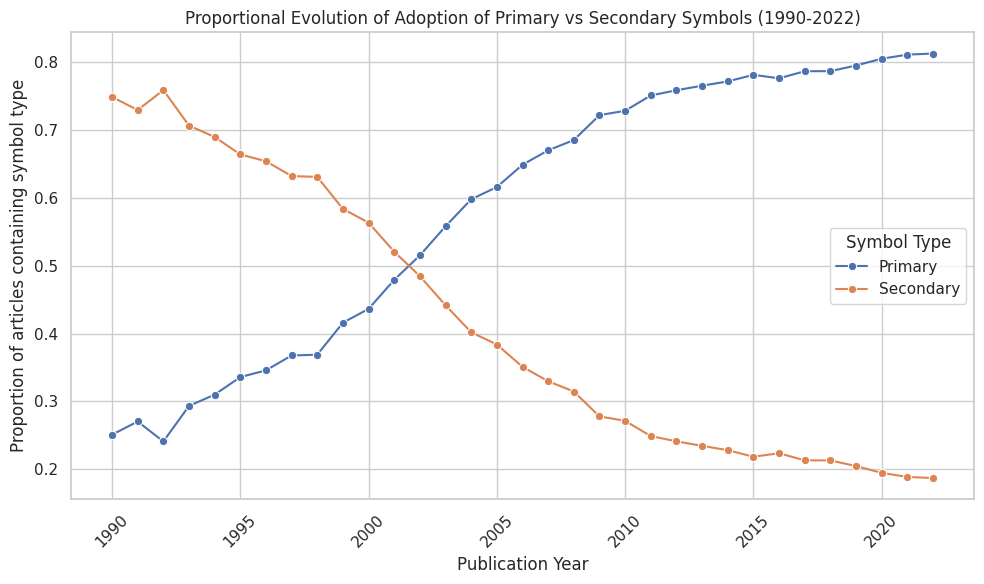

In [7]:
def plot_adoption_evolution(adoption_df, year_range=(2000, 2022)):
    try:

        # Filter by year range
        adoption_df = adoption_df[(adoption_df['pubYear'] >= year_range[0]) & (adoption_df['pubYear'] <= year_range[1])]

        # Create a count plot
        plt.figure(figsize=(10, 6))
        sns.set(style="whitegrid")

        # Count the number of primary symbols for each year
        primary_counts = adoption_df[adoption_df['symbol_type'] == 'primary'].groupby('pubYear').size()

        # Count the number of secondary symbols for each year
        secondary_counts = adoption_df[adoption_df['symbol_type'] == 'secondary'].groupby('pubYear').size()

        primary_normalized = primary_counts / (primary_counts+secondary_counts)
        secondary_normalized = secondary_counts / (primary_counts+secondary_counts)


        # Plot primary and secondary counts
        sns.lineplot(x=primary_normalized.index, y=primary_normalized.values, label='Primary', marker='o')
        sns.lineplot(x=secondary_normalized.index, y=secondary_normalized.values, label='Secondary', marker='o')

        plt.xlabel('Publication Year')
        plt.ylabel('Proportion of articles containing symbol type')
        plt.title(f'Proportional Evolution of Adoption of Primary vs Secondary Symbols ({year_range[0]}-{year_range[1]})')
        plt.legend(title='Symbol Type')
        plt.xticks(rotation=45)
        plt.tight_layout()

        # Show the plot
        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")
plot_adoption_evolution(adoption_df, (1990, 2022))

The primary symbol adoption line shows a plateau from around 2010 at around 80% of primary symbol usage versus 20% of secondary symbol usage.

Below we retrieve the top 10 journals in terms of bibliometric hits for either primary or secondary symbols.

In [8]:
top_10 = adoption_df['journal_title'].value_counts().head(10).index.tolist()
print("-", "\n-".join(top_10))

- PloS one
-The Journal of biological chemistry
-Scientific reports
-International journal of molecular sciences
-Proceedings of the National Academy of Sciences of the United States of America
-Biochemical and biophysical research communications
-Human molecular genetics
-Frontiers in genetics
-Oncotarget
-Blood


## 2. Sec2Pri index

We calculate the sec2pri index for each gene, year and journal.

In [9]:
def sec2pri(df, aggregate_journal = True):
    primary_df = df[df['symbol_type'] == 'primary']
    secondary_df = df[df['symbol_type'] == 'secondary']
    grouped_primary = primary_df.groupby(['journal_title', 'pubYear', 'primarySymbol']).agg({'pmid': 'nunique'}).reset_index()
    grouped_secondary = secondary_df.groupby(['journal_title', 'pubYear', 'secondarySymbol', 'primarySymbol']).agg({'pmid': 'nunique'}).reset_index()
    merged = grouped_primary.merge(grouped_secondary, on=['journal_title', 'pubYear', 'primarySymbol'], how='left')
    merged.rename(columns={'pmid_x': 'pmid_primary', 'pmid_y': 'pmid_secondary'}, inplace=True)
    merged['pmid_secondary'] = merged['pmid_secondary'].fillna(0)
    merged['sec2pri'] = merged['pmid_secondary']/(merged['pmid_secondary']+merged['pmid_primary'])
    
    merged = merged.drop(['secondarySymbol'], axis=1).drop_duplicates()
    if aggregate_journal:
        merged = merged.groupby(['journal_title', 'pubYear']).agg(
            sec2pri_mean=('sec2pri', 'mean'),
            #sec2pri_var=('sec2pri', 'var')
).reset_index()
    #else:
        #merged['sec2pri_var'] = merged.groupby('primarySymbol')['sec2pri'].transform('var')
    return merged

In [10]:
sec2pri_all = sec2pri(adoption_df, False)
sec2pri_all.sample(3)

,journal_title,pubYear,primarySymbol,pmid_primary,pmid_secondary,sec2pri
7358,American journal of medical genetics. Part A,2003,ATP2A2,1,0.0,0.0
157397,Journal of clinical immunology,2010,NLRP1,1,0.0,0.0
126319,Heliyon,2021,ABCD1,1,0.0,0.0


In [11]:
sec2pri_all.describe()

,pubYear,pmid_primary,pmid_secondary,sec2pri
count,289575.000000,289575.000000,289575.000000,289575.000000
mean,2014.960256,1.126036,0.042583,0.017774
std,6.909237,0.516007,0.251058,0.093035
min,1940.000000,1.000000,0.000000,0.000000
25%,2011.000000,1.000000,0.000000,0.000000
50%,2017.000000,1.000000,0.000000,0.000000
75%,2021.000000,1.000000,0.000000,0.000000
max,2024.000000,40.000000,17.000000,0.944444


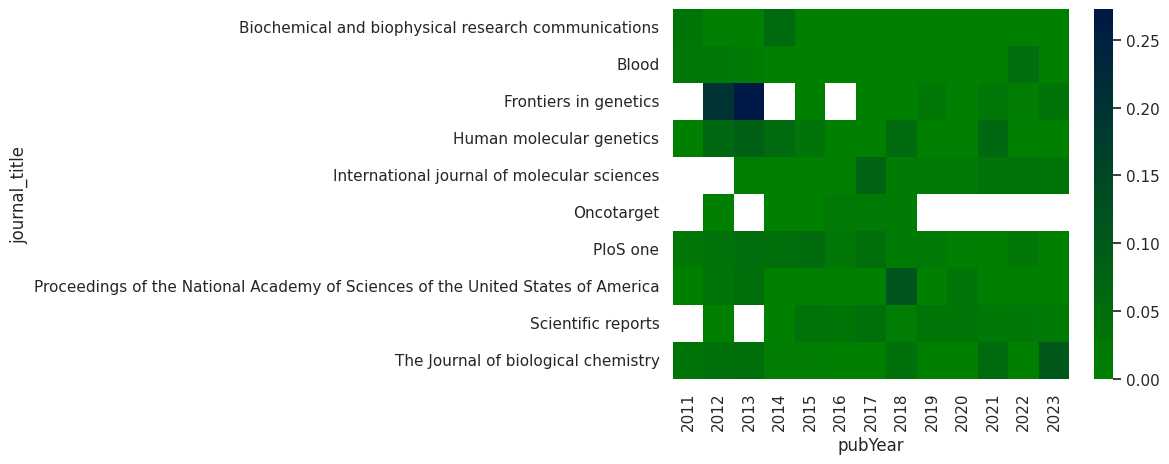

In [12]:
# Pivot the data to create a table with years as columns and journals as rows
sec2pri_filter = sec2pri_all[sec2pri_all['pubYear']>2010]
sec2pri_filter = sec2pri_filter[sec2pri_filter['pmid_primary']>1]
sec2pri_filter = sec2pri_filter[sec2pri_filter['journal_title'].isin(top_10)]
table = sec2pri_filter.pivot_table(index='journal_title', columns='pubYear', values='sec2pri')

# Create the heatmap using seaborn
sns.heatmap(table, cmap='ocean', center=0.5)

# Show the plot
plt.show()

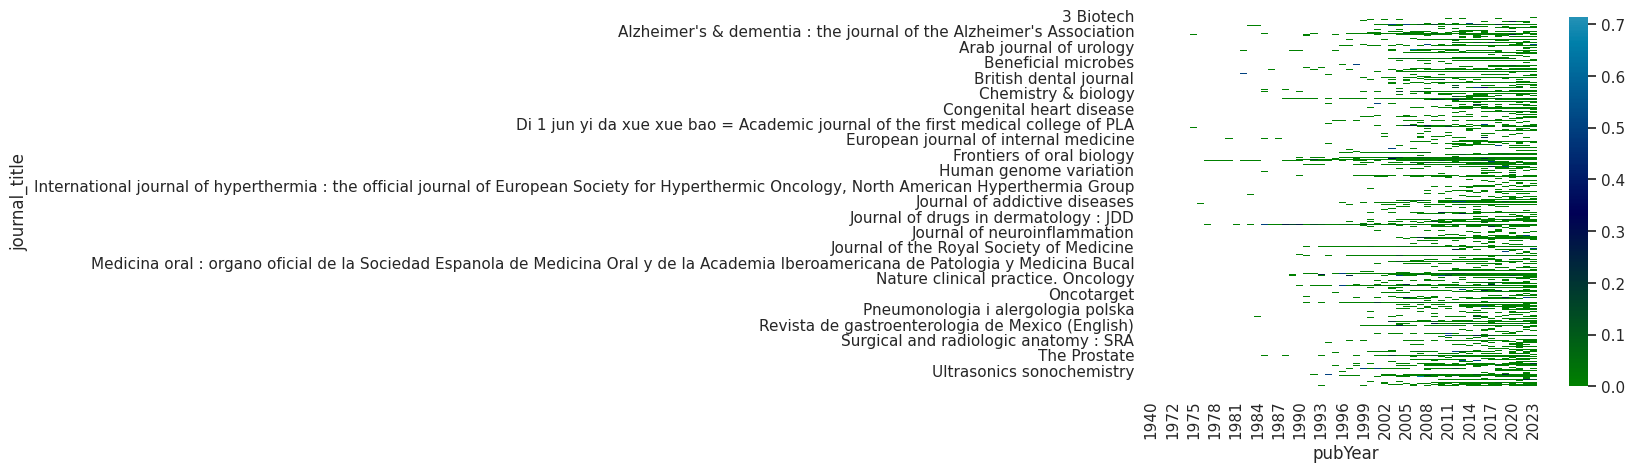

In [13]:
table = sec2pri_all.pivot_table(index='journal_title', columns='pubYear', values='sec2pri')

# Create the heatmap using seaborn
sns.heatmap(table, cmap='ocean', center=0.5)

# Show the plot
plt.show()

The complete plot is not too useful. I doubt we can see al journals in the ticks.

## To be decided, PCA for journals

Attempt to visualize how different journals _cluster_ according to the frequencies in which they publish abstracts containing primary or secondary symbols.

In [14]:
def cluster_journal_symbol(data=adoption_df, n_clusters):
    # Group by journal_title and calculate the frequency of 0s and 1s
    grouped = data.groupby('journal_title')['symbol_type'].value_counts().unstack(fill_value=0)

    # Apply PCA for dimensionality reduction
    n_components = 2
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(grouped)

    # Cluster the data using K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(reduced_features)

    # Create a scatter plot of the clustered data
    plt.figure(figsize=(12, 8))  # Increase figure size for more space

    # Create a mapping of numeric labels to journal titles
    label_to_journal = {}
    for i, journal_title in enumerate(data['journal_title'].unique()):
        label_to_journal[i] = journal_title

    for cluster in range(n_clusters):
        cluster_data = reduced_features[cluster_labels == cluster]

        # Scatter plot with numeric labels
        for i, data_idx in enumerate(np.where(cluster_labels == cluster)[0]):
            plt.scatter(
                cluster_data[i, 0],
                cluster_data[i, 1],
                label=f'Cluster {cluster}',
                alpha=0.7,
                color=f'C{cluster}'
            )
            plt.text(
                cluster_data[i, 0] + 0.01,
                cluster_data[i, 1] + 0.01,
                f'{data_idx}',
                fontsize=10
            )

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('Clustered Journals by symbol type usage')
    
    # Create a color legend for clusters
    color_legend = plt.legend(title='Cluster', loc='upper left', bbox_to_anchor=(1, 1))
    
    # Create a numeric legend for journal titles without the legend box
    num_legend_labels = [f'{data_idx}: {label_to_journal[data_idx]}' for data_idx in range(len(label_to_journal))]
    num_legend_handles = [plt.Line2D([], [], color='white', marker='', label=label) for label in num_legend_labels]
    
    plt.legend(handles=num_legend_handles, title='Journal Titles', loc='upper left', bbox_to_anchor=(1, 0.7))
    
    
    plt.show()

SyntaxError: non-default argument follows default argument (2189437616.py, line 1)